### 데이터 구성 <br>
#### data_raw 폴더 아래에
- {name}_OHLCV.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT, GLD
- 일별 데이터
- 첫 행 : Date, Close, High, Low, Open, Volume, Ticker
- 둘째 행 : , GLD, GLD, GLD, GLD, GLD

#### monthly_return 폴더 아래에
- {name}_monthly_return.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT, GLD
- 월별 리턴 (월간 수익률) 데이터
- 첫 행 : Date, Monthly Return

#### data_monthly 폴더 아래에
- {name}_monthly.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT, GLD
- 월별 가격 (월간 종가) 데이터
- 첫 행 : Date, Monthly Close

#### dividend_data 폴더 아래에
- {name}_dividends.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT 존재 (GLD는 없음)
- 배당 데이터
- 첫 행 : Date, Dividend

#### total_return 폴더 아래에
- {name}_total_return.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT, GLD
- 배당 재투자 반영한 누적 수익률 데이터
- 첫 행 : Date, Monthly Return, Monthly Close, Dividend Yield, Total Return, Cumulative Return

# 1. 데이터 로딩 및 전처리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os

# seaborn 스타일 설정
sns.set_style('whitegrid')
sns.set_context('talk')

# 종목 리스트
tickers = ['JEPI', 'QQQ', 'SCHD', 'SPY', 'TLT', 'GLD']

# 폴더 경로
data_raw_path = './data_raw'
monthly_return_path = './monthly_return'
data_monthly_path = './data_monthly'
dividend_data_path = './dividend_data'
total_return_path = './total_return'

# 1) 일별 OHLCV 데이터 읽기
ohlcv_dfs = {}
for t in tickers:
    file = os.path.join(data_raw_path, f"{t}_OHLCV.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    ohlcv_dfs[t] = df

# 2) 월별 가격(종가) 데이터 읽기
monthly_close_dfs = {}
for t in tickers:
    file = os.path.join(data_monthly_path, f"{t}_monthly.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    monthly_close_dfs[t] = df

# 3) 월별 수익률 데이터 읽기
monthly_return_dfs = {}
for t in tickers:
    file = os.path.join(monthly_return_path, f"{t}_monthly_return.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    monthly_return_dfs[t] = df

# 4) 배당 데이터 (GLD 없음)
dividend_dfs = {}
for t in ['JEPI', 'QQQ', 'SCHD', 'SPY', 'TLT']:
    file = os.path.join(dividend_data_path, f"{t}_dividends.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    dividend_dfs[t] = df

# 5) 배당 재투자 누적 수익률 데이터
total_return_dfs = {}
for t in tickers:
    file = os.path.join(total_return_path, f"{t}_total_return.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    total_return_dfs[t] = df

# 2. 포트폴리오 구성 및 계산

In [2]:
# 포트폴리오 가중치 (월별 수익률 기준)
portfolios = {
    'Stable': {'SPY': 0, 'SCHD': 0.28, 'QQQ': 0.12, 'TLT': 0.25, 'GLD': 0.35},
    'Aggressive': {'SPY': 0.4, 'SCHD': 0.25, 'QQQ': 0.25, 'TLT': 0.05, 'GLD': 0.05}
}

# 개별 종목 : SPY, SCHD, QQQ, TLT, GLD, JEPI
# 혼합 종목들은 가중 수익률 계산용 이름
mixed_tickers = {
    'SCHD7_QQQ3': {'SCHD':0.7, 'QQQ':0.3},
    'SCHD5_QQQ5': {'SCHD':0.5, 'QQQ':0.5},
    'SPY6_TLT4': {'SPY':0.6, 'TLT':0.4},
    'SPY9_TLT1': {'SPY':0.9, 'TLT':0.1},
    'SPY5_GLD4': {'SPY':0.5, 'GLD':0.5},
    'SPY9_GLD1': {'SPY':0.9, 'GLD':0.1}
}

In [3]:
# 모든 분석할 종목 리스트 (개별 + 혼합)
all_tickers = tickers + list(mixed_tickers.keys())

# 월별 수익률 데이터로 포트폴리오 및 혼합 종목 수익률 계산
def calc_mixed_monthly_return(weights_dict, monthly_return_dfs):
    # 날짜 기준 통합 인덱스 생성
    date_index = monthly_return_dfs['SPY'].index

    # 가중 평균 수익률 계산용 DataFrame
    df = pd.DataFrame(index=date_index)

    for name, weights in weights_dict.items():
        # 종목별 월별 수익률을 가져와서 가중평균 계산
        ret = pd.Series(0, index=date_index, dtype=float)
        for t, w in weights.items():
            ret += monthly_return_dfs[t]['Monthly Return'] * w
        df[name] = ret

    return df

# 혼합 종목 월별 수익률 계산
mixed_returns_df = calc_mixed_monthly_return(mixed_tickers, monthly_return_dfs)

# 개별 종목 월별 수익률 합치기
indiv_returns_df = pd.DataFrame({t: monthly_return_dfs[t]['Monthly Return'] for t in tickers})

# 전체 종목(개별+혼합) 월별 수익률 데이터프레임
all_returns_df = pd.concat([indiv_returns_df, mixed_returns_df], axis=1)

# 3. 자산별 상관관계 (상관계수)

In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 윈도우 한글폰트 설정 (맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'

# 음수 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

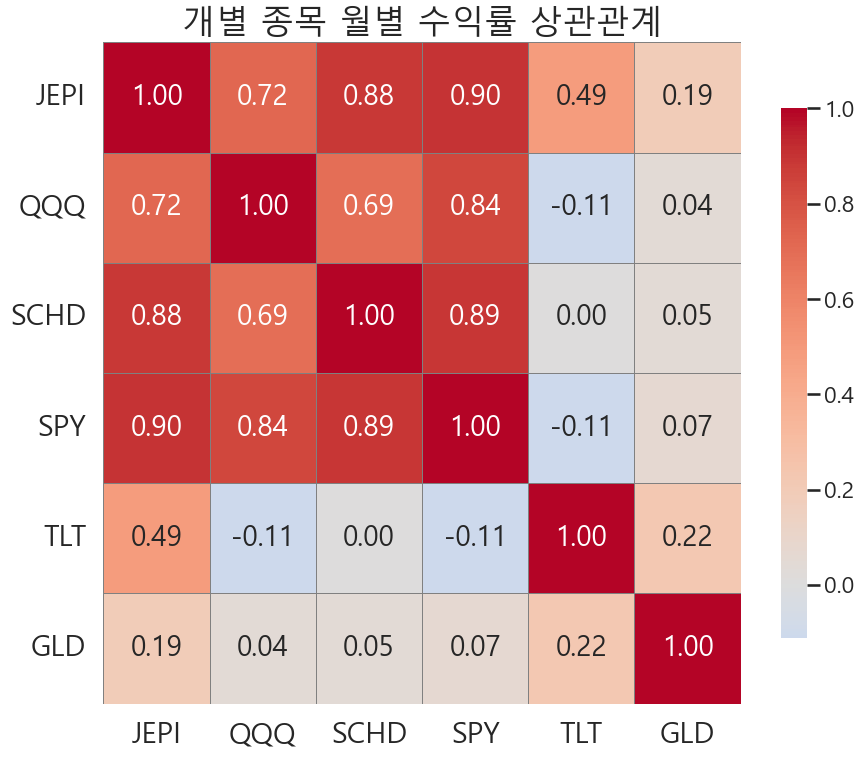

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 폰트 크기 설정
plt.rcParams.update({'font.size': 20})

# 1. 개별 종목 월별 수익률 데이터프레임 준비 (이미 indiv_returns_df에 있음)
# indiv_returns_df.columns 는 tickers 리스트와 동일하며, 각 컬럼은 월별 수익률 시계열임

# 2. 개별 종목끼리 상관계수 계산
corr_matrix = indiv_returns_df.corr()

# 3. 상관계수 히트맵 시각화
plt.figure(figsize=(9.5, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            linewidths=0.5, linecolor='gray', cbar_kws={"shrink": .8})

plt.title("개별 종목 월별 수익률 상관관계", fontsize=24)
plt.xticks(rotation=0, fontsize=21)
plt.yticks(rotation=0, fontsize=21)
plt.tight_layout()
plt.show()

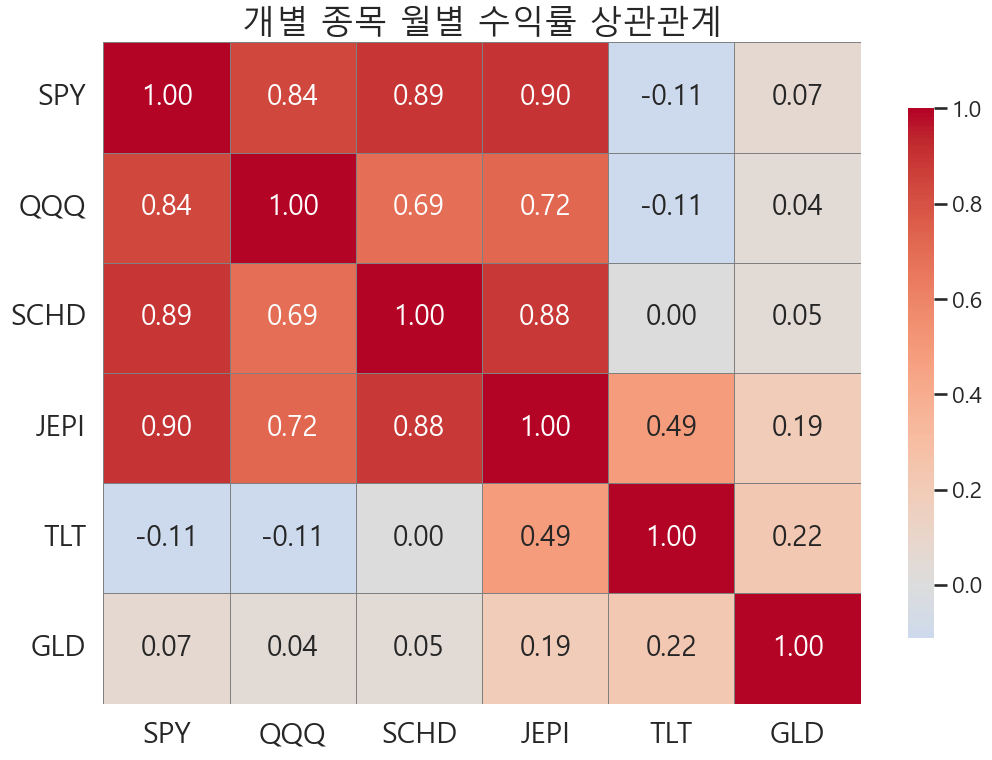

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 폰트 크기 설정
plt.rcParams.update({'font.size': 20})

# 원하는 순서 지정
ordered_tickers = ['SPY', 'QQQ', 'SCHD', 'JEPI', 'TLT', 'GLD']

# 상관계수 계산
corr_matrix = indiv_returns_df.corr()

# 순서 변경
corr_matrix = corr_matrix.loc[ordered_tickers, ordered_tickers]

# 히트맵 시각화
plt.figure(figsize=(11, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            linewidths=0.5, linecolor='gray', cbar_kws={"shrink": .8})

plt.title("개별 종목 월별 수익률 상관관계", fontsize=24)
plt.xticks(rotation=0, fontsize=21)
plt.yticks(rotation=0, fontsize=21)
plt.tight_layout()
plt.show()

In [7]:
import numpy as np
import pandas as pd

# 1. 상관계수 행렬 계산
corr_matrix = indiv_returns_df.corr()

# 2. 대각선 제외 (자기 자신 상관계수 NaN 처리)
corr_matrix = corr_matrix.where(~np.eye(corr_matrix.shape[0], dtype=bool))

# 3. 상관계수 행렬 1차원으로 펼치기
corr_unstacked = corr_matrix.unstack().dropna()

# 4. (A,B) 와 (B,A) 중복 제거
corr_unstacked.index = corr_unstacked.index.map(lambda x: tuple(sorted(x)))
corr_unique = corr_unstacked[~corr_unstacked.index.duplicated(keep='first')]

# 5. 내림차순 정렬
corr_sorted = corr_unique.sort_values(ascending=False)

# 6. 상위 15개만 추출
top_15 = corr_sorted.head(15)

# 7. 보기 좋게 DataFrame으로 변환
top_15_df = top_15.reset_index()
top_15_df.columns = ['Ticker1', 'Ticker2', 'Correlation']

print(top_15_df)

   Ticker1 Ticker2  Correlation
0     JEPI     SPY     0.902746
1     SCHD     SPY     0.889873
2     JEPI    SCHD     0.884855
3      QQQ     SPY     0.838931
4     JEPI     QQQ     0.720618
5      QQQ    SCHD     0.694703
6     JEPI     TLT     0.492205
7      GLD     TLT     0.222406
8      GLD    JEPI     0.192150
9      GLD     SPY     0.071194
10     GLD    SCHD     0.047727
11     GLD     QQQ     0.042244
12    SCHD     TLT     0.003147
13     QQQ     TLT    -0.106285
14     SPY     TLT    -0.110507


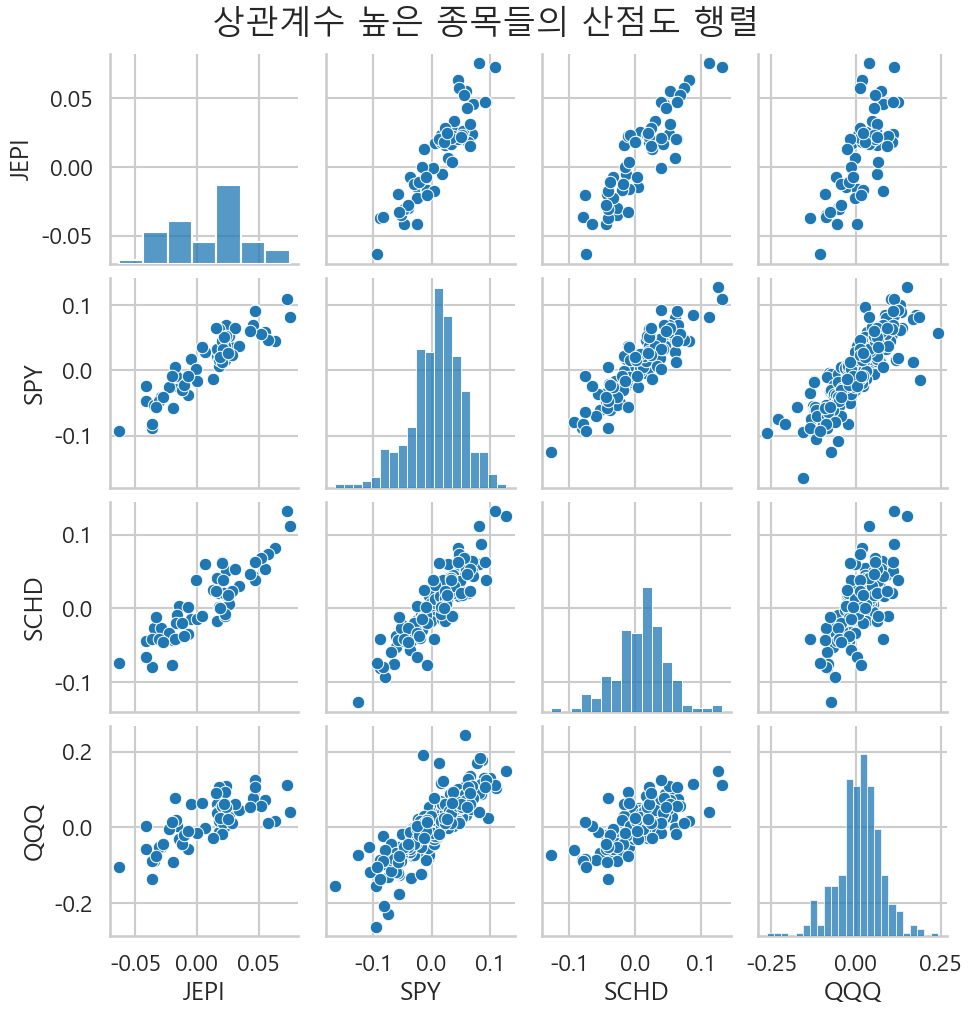

In [8]:
import seaborn as sns

# 상관계수 높은 종목들만 선택 (예: 상위 4개 종목)
top_tickers = corr_matrix.sum().sort_values(ascending=False).index[:4]

sns.pairplot(indiv_returns_df[top_tickers])
plt.suptitle('상관계수 높은 종목들의 산점도 행렬', y=1.02)
plt.show()